# ARIMA Model
For the ARIMA model every country we look at will get their own moving ARIMA model.

In [1]:
import pandas as pd
sys.path.append('../')
from utils import get_data, ad_test, evaluate_model, create_ridge_model
import matplotlib.pyplot as plt
import wbgapi as wb
from pmdarima import auto_arima
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import joblib
import xgboost as xgb
import pickle
import numpy as np
import matplotlib.pyplot as plt




In [2]:
# Extract the life expectancy for india
countries = ['ind']

data_life_exp = get_data('SP.DYN.LE00.IN', countries)

In [3]:
# Look at life exp for India
data_life_exp

,Country,Date,Value
0,India,2022,NaN
1,India,2021,67.240
2,India,2020,70.150
3,India,2019,70.910
4,India,2018,70.710
5,India,2017,70.467
6,India,2016,70.117
7,India,2015,69.636
8,India,2014,69.074
9,India,2013,68.460


In [4]:
# Convert 'Date' column to datetime type
data_life_exp['Date'] = pd.to_datetime(data_life_exp['Date'], format= '%Y')

# Set 'Date' column as the index
data_life_exp.set_index('Date', inplace=True)

In [5]:
# Fill nas with previous value
data_life_exp = data_life_exp.fillna(method='ffill')

# Drop NA's
data_life_exp = data_life_exp.dropna()

# Rename Value
data_life_exp= data_life_exp.rename(columns={'Value': 'life_exp'})

<Axes: xlabel='Date'>

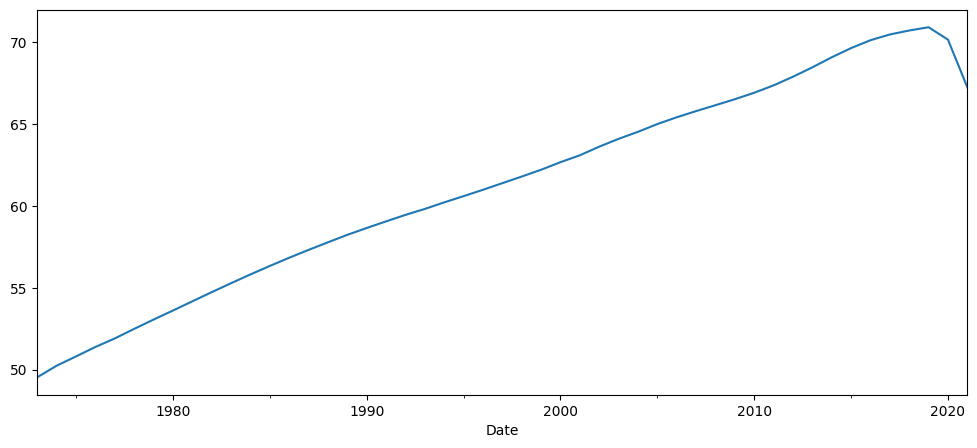

In [6]:
# Plot indias life exp
data_life_exp['life_exp'].plot(figsize=(12,5))

# Explore Stationarity of the Dataset
Use statistical test to find out if the Dataset is stationar

In [7]:
# run function to test stationariety
ad_test(data_life_exp['life_exp'])

ADF:  2.308644032297438
p-value:  0.9989606083611171
Number of Lags: 1
Number of Observations used: 47
critical Values: {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}
	 1% :  -3.5778480370438146
	 5% :  -2.925338105429433
	 10% :  -2.6007735310095064


P-value is really high which indicates that the data is not-stationary. This is expected because the data as we looked at it follows a clear trend. Therefore ARIMA Models are most likely not the best fit. We try out one ARIMA model as a baseline for following modeling.

# ARIMA Models
ARIMA stands for 
(AR) Auto Regression -> previous values to make a prediction
(MA) Moving Avergae -> Past areas for prediction
(I) Integrated -> differencing eliminating the trends 

In [8]:
# Try out different arima parameters
stepwise_fit = auto_arima(data_life_exp['life_exp'], trace = True, supress_warnings=True)
stepwise_fit.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5.537, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=77.031, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=43.124, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=50.857, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=94.724, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.216, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6.171, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16.143, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10.931, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-6.387, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-6.649, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-6.488, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-4.391, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-8.144, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=9.901, Time=0.01 sec

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   49
Model:               SARIMAX(4, 1, 0)   Log Likelihood                   9.079
Date:                Tue, 01 Aug 2023   AIC                             -8.158
Time:                        14:28:03   BIC                              1.198
Sample:                             0   HQIC                            -4.622
                                 - 49                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.8037      0.184     15.197      0.000       2.442       3.165
ar.L2         -3.0826      0.254    -12.138      0.000      -3.580      -2.585
ar.L3          1.5969      0.227      7.048      0.000       1.153       2.041
ar.L4         -0.3385      0.081     -4.203      0.000      -0.496      -0.181
sigma2         0.0328      0.005      6.408      0.000       0.023       0.043
===================================================================================
Ljung-Box (L1) (Q):                  17.38   Jarque-Bera (JB):                46.35
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Best model is a SARIMA Model (ARIMA Model with seasonality) with the parameters (4,1,0)

In [9]:
# Split the data in train and test
train = data_life_exp.iloc[:-44]
test = data_life_exp.iloc[-44:]
print(train.shape, test.shape)

(5, 2) (44, 2)


In [10]:
# Create the sarima model
model = sm.tsa.statespace.SARIMAX(train['life_exp'], order = (4,1,0))
# Fit the model
model = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49109D+00    |proj g|=  2.57872D-01

At iterate    5    f=  1.29532D+00    |proj g|=  1.57848D-02

At iterate   10    f=  1.29524D+00    |proj g|=  2.63470D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   1.929D-05   1.295D+00
  F =   1.2952401601548631     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations t

In [11]:
# Print model summary
model.summary()

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:3159: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:3159: UserWarning: Later subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               life_exp   No. Observations:                    5
Model:               SARIMAX(4, 1, 0)   Log Likelihood                  -6.476
Date:                Tue, 01 Aug 2023   AIC                             22.952
Time:                        14:28:03   BIC                             19.884
Sample:                             0   HQIC                            16.219
                                  - 5                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8002   4.26e+04   4.22e-05      1.000   -8.35e+04    8.35e+04
ar.L2         -1.4259   6.62e+04  -2.15e-05      1.000    -1.3e+05     1.3e+05
ar.L3          0.4883   8985.981   5.43e-05      1.000   -1.76e+04    1.76e+04
ar.L4      -4.339e-06    4.5e+04  -9.65e-11      1.000   -8.81e+04    8.81e+04
sigma2         0.6204   7.15e+04   8.67e-06      1.000    -1.4e+05     1.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.40   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.04   Prob(JB):                         0.80
Heteroskedasticity (H):                nan   Skew:                            -0.33
Prob(H) (two-sided):                   nan   Kurtosis:                         1.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.72e+16. Standard errors may be unstable.
"""

In [12]:
# Make predictions
pred = model.predict(start = len(train), end = (len(train) + len(test)-1), typ = 'levels' )
pred.index = data_life_exp.index[len(train):(len(train) + len(test))]
print(pred)

Date
2016-01-01    70.685860
2015-01-01    71.328674
2014-01-01    72.055102
2013-01-01    72.553055
2012-01-01    72.727518
2011-01-01    72.686262
2010-01-01    72.606384
2009-01-01    72.606609
2008-01-01    72.700769
2007-01-01    72.830944
2006-01-01    72.931125
2005-01-01    72.971826
2004-01-01    72.965813
2003-01-01    72.945869
2002-01-01    72.938418
2001-01-01    72.950507
2000-01-01    72.973153
1999-01-01    72.993044
1998-01-01    73.002464
1997-01-01    73.002114
1996-01-01    72.997768
1995-01-01    72.995041
1994-01-01    72.996159
1993-01-01    72.999939
1992-01-01    73.003816
1991-01-01    73.005952
1990-01-01    73.006114
1989-01-01    73.005255
1988-01-01    73.004518
1987-01-01    73.004497
1986-01-01    73.005090
1985-01-01    73.005828
1984-01-01    73.006300
1983-01-01    73.006388
1982-01-01    73.006232
1981-01-01    73.006058
1980-01-01    73.006010
1979-01-01    73.006094
1978-01-01    73.006230
1977-01-01    73.006332
1976-01-01    73.006361
1975-01-01 

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='Date'>

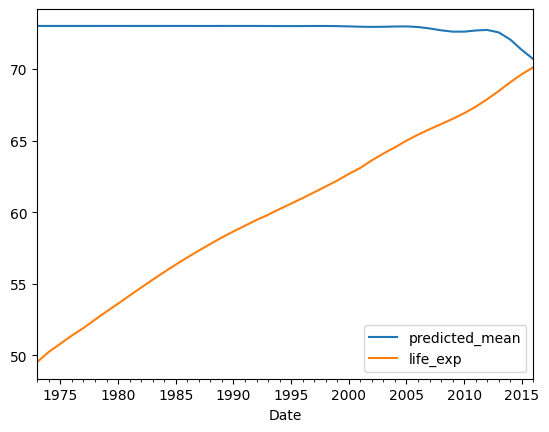

In [13]:
# Plot predictions
pred.plot(legend=True)
test['life_exp'].plot(legend = True)

We can conclude that using ARMIA Models makes no sense because of the non-statinarity of data

# Regression Models
We try out the following different regression Models in order to find the best one 
______
Linear Regression
______
Ridge Regression
______
Lasso Regression
______
Elastic Net Regression
______

to fit the models we are using our already preprocessed data without null values.

In [14]:
# Read in data
df_reg = pd.read_csv('/Users/kevingiesen/Library/Mobile Documents/com~apple~CloudDocs/BIPM Master/Semester 2/Big Data/Big Data Project 3/SS23-BIPM-Big-Data-Group-KMJ-Do-Gooders/app/predicition model/data/data_no_nas.csv')

In [15]:
# Filter out the year 2021 and 2022
df_reg = df_reg[~(df_reg['Date'] >= 2021)]

In [16]:
# Show head of the data 
df_reg.head()

,Country,Date,life_exp,access_to_electricity,trade_in_services,foreign_investm,perc_overweigth,child_immunization,gdp_per_cap,net_primary_income,rural_population,primary_school_completion,armed_forces,measels_immunitization
2,Africa Eastern and Southern,2020,63.313856,30.163364,8.216086,-0.233143,20.287872,80.663899,1363.540741,6.741908e+07,63.171699,71.969162,1.480009e+06,72.787530
3,Africa Eastern and Southern,2019,63.755674,29.383000,10.505307,0.220475,19.988626,82.569817,1512.270553,6.741908e+07,63.663742,70.913277,1.344000e+06,74.437970
4,Africa Eastern and Southern,2018,63.365858,27.227391,10.967405,0.537286,19.689380,82.179562,1564.734340,6.741908e+07,64.152404,70.197662,1.343720e+06,73.259705
5,Africa Eastern and Southern,2017,62.922385,25.153292,10.308782,1.336439,19.390134,83.068022,1628.586788,6.741908e+07,64.641102,68.664902,1.314000e+06,73.908385
6,Africa Eastern and Southern,2016,62.444045,24.372504,11.122923,0.874440,19.865981,82.303035,1443.692371,6.741908e+07,65.105250,67.479813,1.336740e+06,73.324259


### First trial with one Country India 
This try focusses on fitting one regression model for one country (India)

In [17]:
# Select data for India 
df_reg_india = df_reg[(df_reg['Country'] == 'India')]

In [18]:
# Data splitting 
target = df_reg_india['life_exp']
features = df_reg_india[df_reg_india.columns.difference(['life_exp', 'Date'])]

# Split in train and test
x_train, x_test, y_train, y_test = train_test_split(pd.get_dummies(features), target, test_size=0.3)


In [19]:
# Create Linear Regression model
model_lr = LinearRegression()

# Fitting model over training data
model_lr.fit(x_train, y_train)

# Evaluating the model over test data 
lr_confidence = model_lr.score(x_test, y_test)
print("test score for the model: ", lr_confidence)

test score for the model:  0.9977093738595411


## Linear Regression for all countries

we want to perform the Linear Regression over all countries and calculate the performance score for all of them in order to see how the Linear Regression performs over the whole data.


In [20]:
# Array to store all test scores in order to average them out in the end
all_scores = []
countries_low_score = {}
countries_high_score = {}


# Loop over all countrys in the dataframe
for country in df_reg['Country'].unique():
    
    country_data = df_reg[df_reg["Country"] == country]

    # Data splitting 
    target = country_data['life_exp']
    features = country_data[country_data.columns.difference(['life_exp', 'Date'])]

    # Split in train and test
    x_train, x_test, y_train, y_test = train_test_split(pd.get_dummies(features), target, test_size=0.3, random_state=42)

    # Create Linear Regression model
    model_lr = LinearRegression()

    # Fitting model over training data
    model_lr.fit(x_train, y_train)

    # Evaluating the model over test data 
    lr_confidence = model_lr.score(x_test, y_test)

    # Append current confidence score 
    all_scores.append(lr_confidence)        

    # If score lower than 60% drop the country data
    if lr_confidence < 0.6:
        countries_low_score[country] = lr_confidence
    
    else:
        countries_high_score[country] = lr_confidence
        

    


## Results of Linear Regression

In [21]:
# Show the average score 
average = sum(all_scores) / len(all_scores)
lin_reg_score = average
print('Avergae score of Linear Regression: ' , str(average))

Avergae score of Linear Regression:  0.8284207531234272


In [22]:
# Examining countries with low score 
# Calculate average score for countries with a low score 
values = list(countries_low_score.values())
average = sum(values) / len(values)
                            
# Print out the number of countries and their average score
print('Number of countries with a low score: ' ,  str(len(countries_low_score)), '\n', 
      'Average Score for countries with low scores: ' , str(average))

# Print out the countries and their score
print(countries_low_score)

Number of countries with a low score:  25 
 Average Score for countries with low scores:  -0.214549036521158
{'Belarus': -0.42863350231417763, 'Central African Republic': 0.27785689122286905, 'Curacao': -1.5760433980214739, 'Cayman Islands': 0.5423231971079845, 'Dominica': -1.4076204266106465, 'Kazakhstan': 0.5386848276699732, 'Lesotho': 0.558275234141405, 'Lithuania': 0.5838247853469904, 'Latvia': -0.4973866157755331, 'Montenegro': 0.19929703595630677, 'Namibia': 0.09916424497538001, 'Nauru': -2.8846410269732883, 'Palau': 0.16212340622134003, "Korea, Dem. People's Rep.": 0.567965013783559, 'Russian Federation': -0.9702037651745807, 'Rwanda': 0.302367428056907, 'Somalia': -0.664007603550953, 'South Sudan': -2.906392643078508, 'Eswatini': -0.024531725016588624, 'Seychelles': -0.2688069863515623, 'Syrian Arab Republic': 0.5271774799818012, 'Turks and Caicos Islands': 0.568439241370684, 'Tajikistan': 0.37248644781912077, 'St. Vincent and the Grenadines': 0.38755588812697206, 'South Africa

In [23]:
# Calculate average score for countries with a low score 
values = list(countries_high_score.values())
average = sum(values) / len(values)
                            
# Print out the number of countries and their average score
print('Number of countries with a low score: ' ,  str(len(countries_high_score)), '\n', 
      'Average Score for countries with low scores: ' , str(average))

Number of countries with a low score:  240 
 Average Score for countries with low scores:  0.9370634395447386


## Conclusion Linear Regression
Examining the Countries with the low score we found that those countries also have insufficient data which we pulled from the API. The more relevant for us is how good our model performs on the data where we also have complete and sufficient data. This is because we cannot influence the data quality from the API and the data quality is most likely the issue for the low scores. 

# Ridge Regression
Because the functionality of fitting the model and calculating the scores is similiar for all regression models therefore we attached a function to the utils where the model is delivered as in input and the calculation is done when the function is called evaluate_model and returns the all scores for all countries (all_scores), a list of countries with low scores (countries_low_score), a list of countries with high scores (countries_high_score), and the fitted model


## Results of Ridge Regression

In [24]:
# Call the function to calculate the scores for the model
all_scores_ridge, all_mses_ridge, countries_low_score_ridge, countries_high_score_ridge, countries_high_mse_ridge, models_ridge = evaluate_model(df_reg, model = Ridge(alpha=1.0))

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.28471e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.66295e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.15909e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.87789e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: Li

In [25]:
# Show the average score 
average = sum(all_scores_ridge) / len(all_scores_ridge)
average_mse =sum(all_mses_ridge) / len(all_mses_ridge)

ridge_reg_score = average

print('Avergae score of Ridge Regression: ' , str(average), '\n', 'Average MSE Score: ' , str(average_mse))

Avergae score of Ridge Regression:  0.8583010519953169 
 Average MSE Score:  2.518923144625372


In [26]:
# Examining countries with low score 
# Calculate average score for countries with a low score 
values = list(countries_low_score_ridge.values())
average = sum(values) / len(values)
                            
# Print out the number of countries and their average score
print('Number of countries with a low score: ' ,  str(len(countries_low_score_ridge)), '\n', 
      'Average Score for countries with low scores: ' , str(average))

# Print out the countries and their score
print(countries_low_score_ridge)

Number of countries with a low score:  23 
 Average Score for countries with low scores:  0.020307906628620427
{'Belarus': -0.5019518235582763, 'Central African Republic': 0.45301646389315087, 'Curacao': 0.28438759166379457, 'Cayman Islands': 0.5425667322048042, 'Dominica': -1.0667619054457527, 'Kazakhstan': 0.389666147511023, 'Lesotho': 0.5066828876551099, 'Lithuania': 0.5953673011533368, 'Latvia': -0.35255645394110413, 'Montenegro': 0.36826729520502244, 'Namibia': 0.10855407983768806, 'Nauru': -2.572867454089747, 'Palau': 0.17050688495249444, "Korea, Dem. People's Rep.": 0.5743593566097469, 'Russian Federation': -0.6298264544877505, 'Rwanda': 0.28871654119260115, 'Somalia': -0.6639223956426457, 'Eswatini': 0.24880416630273583, 'Seychelles': -0.2660955623114982, 'Syrian Arab Republic': 0.43728583923545294, 'Turks and Caicos Islands': 0.5689143747752795, 'Tajikistan': 0.43481050128882537, 'South Africa': 0.5491577384539783}


In [27]:
# Calculate average score for countries with a high score 
values = list(countries_high_score_ridge.values())
average = sum(values) / len(values)

values_mse = list(countries_high_mse_ridge.values())
average_mse = sum(values_mse) / len(values_mse)

                            
# Print out the number of countries and their average score
print('Number of countries with a high score: ' ,  str(len(countries_high_score_ridge)), '\n', 
      'Average Score for countries with a high scores: ' , str(average), '\n',
      'Average MSE for countries with a high scores: ' , str(average_mse))


Number of countries with a high score:  242 
 Average Score for countries with a high scores:  0.9379450286210776 
 Average MSE for countries with a high scores:  1.5321917190402237


# Lasso Regression
Same procedure than for Ridge


In [28]:
# Call the function to calculate the scores for the model
all_scores_lasso, all_mses_lasso, countries_low_score_lasso, countries_high_score_lasso, countries_high_mse_lasso, models_lasso = evaluate_model(df_reg, model = Lasso(alpha=1.0))

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.213e+01, tolerance: 3.685e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 

In [29]:
# Show the average score 
average = sum(all_scores_lasso) / len(all_scores_lasso)
average_mse =sum(all_mses_lasso) / len(all_mses_lasso)

lasso_reg_score = average

print('Avergae score of Lasso Regression: ' , str(average), '\n', 'Average MSE Score: ' , str(average_mse))

Avergae score of Lasso Regression:  0.8663833674001746 
 Average MSE Score:  2.5107354117302636


In [30]:
# Examining countries with low score 
# Calculate average score for countries with a low score 
values = list(countries_low_score_lasso.values())
average = sum(values) / len(values)
                            
# Print out the number of countries and their average score
print('Number of countries with a low score: ' ,  str(len(countries_low_score_lasso)), '\n', 
      'Average Score for countries with low scores: ' , str(average))

# Print out the countries and their score
print(countries_low_score_lasso)

Number of countries with a low score:  18 
 Average Score for countries with low scores:  0.13946122206500658
{'Belarus': 0.4185318314003744, 'Curacao': 0.5589193147917724, 'Cayman Islands': 0.5910040071455989, 'Dominica': -0.41255527875599474, 'Jamaica': 0.4379429657369185, 'Kazakhstan': -1.4996013906175736, 'Lesotho': 0.29979415144598187, 'Namibia': 0.08565887823944929, 'Nauru': -0.02162941609548996, 'Palau': 0.3926982316856137, "Korea, Dem. People's Rep.": 0.5665300507864534, 'Russian Federation': 0.4366982440232896, 'Rwanda': 0.31025274147271587, 'Somalia': -0.5860507770982386, 'Syrian Arab Republic': -0.016446685198027167, 'Tajikistan': 0.43282457338335545, 'Ukraine': 0.43947654498750954, 'South Africa': 0.07625400983640906}


In [31]:
# Calculate average score for countries with a high score 
values = list(countries_high_score_lasso.values())
average = sum(values) / len(values)

values_mse = list(countries_high_mse_lasso.values())
average_mse = sum(values_mse) / len(values_mse)

                            
# Print out the number of countries and their average score
print('Number of countries with a high score: ' ,  str(len(countries_high_score_lasso)), '\n', 
      'Average Score for countries with a high scores: ' , str(average), '\n',
      'Average MSE for countries with a high scores: ' , str(average_mse))

Number of countries with a high score:  247 
 Average Score for countries with a high scores:  0.9193574508658954 
 Average MSE for countries with a high scores:  1.6553322472183312


## Conclusion Lasso 
The performance of the Lasso Regression seems to be 

# Elastic Net (combination of Ridge and Lasso)

In [32]:
# Call the function to calculate the scores for the model
all_scores_elasticnet, all_mses_elasticnet, countries_low_score_elasticnet, countries_high_score_elasticnet, countries_high_mse_elasticnet, models_elasticnet = evaluate_model(df_reg, model = ElasticNet(alpha=1.0, l1_ratio=0.5))

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.322e+01, tolerance: 

In [33]:
# Show the average score 
average = sum(all_scores_elasticnet) / len(all_scores_elasticnet)
average_mse =sum(all_mses_elasticnet) / len(all_mses_elasticnet)

elastic_net_score = average

print('Avergae score of Elastic Net: ' , str(average), '\n', 'Average MSE Score: ' , str(average_mse))

Avergae score of Elastic Net:  0.8716916552988011 
 Average MSE Score:  2.465560420951866


In [34]:
# Examining countries with low score 
# Calculate average score for countries with a low score 
values = list(countries_low_score_elasticnet.values())
average = sum(values) / len(values)
                            
# Print out the number of countries and their average score
print('Number of countries with a low score: ' ,  str(len(countries_low_score_elasticnet)), '\n', 
      'Average Score for countries with low scores: ' , str(average))

# Print out the countries and their score
print(countries_low_score_elasticnet)

Number of countries with a low score:  18 
 Average Score for countries with low scores:  0.14554912590109506
{'Belarus': 0.3311374551747842, 'Curacao': 0.4686139887307743, 'Cayman Islands': 0.5702161112877446, 'Dominica': -0.33559706547402324, 'Jamaica': 0.583432083862814, 'Kazakhstan': -1.1679817035213755, 'Lesotho': 0.3065750271037889, 'Namibia': 0.09419880953842064, 'Nauru': -0.05490810161584303, 'Palau': 0.3515040776091126, "Korea, Dem. People's Rep.": 0.5727826596617587, 'Russian Federation': 0.24821053924531677, 'Rwanda': 0.28777772020314096, 'Somalia': -0.648194142537887, 'Syrian Arab Republic': -0.051934756673371885, 'Tajikistan': 0.4524261343426249, 'Ukraine': 0.4438357784433482, 'South Africa': 0.16778965083858277}


In [35]:
# Calculate average score for countries with a high score 
values = list(countries_high_score_elasticnet.values())
average = sum(values) / len(values)

values_mse = list(countries_high_mse_elasticnet.values())
average_mse = sum(values_mse) / len(values_mse)

                            
# Print out the number of countries and their average score
print('Number of countries with a high score: ' ,  str(len(countries_high_score_elasticnet)), '\n', 
      'Average Score for countries with a high scores: ' , str(average), '\n',
      'Average MSE for countries with a high scores: ' , str(average_mse))

Number of countries with a high score:  247 
 Average Score for countries with a high scores:  0.9246089246476217 
 Average MSE for countries with a high scores:  1.5949148565007665


In [36]:
# look at the elastic net for US
models_elasticnet['United States']

ElasticNet()

In [37]:
# Store Features for the US
models_elasticnet['United States'].feature_names_in_

array(['access_to_electricity', 'armed_forces', 'child_immunization',
       'foreign_investm', 'gdp_per_cap', 'measels_immunitization',
       'net_primary_income', 'perc_overweigth',
       'primary_school_completion', 'rural_population',
       'trade_in_services', 'Country_Zimbabwe'], dtype=object)

# Create a Ridge Model
Because of previous evaluations we discovered that the Ridge model gives us the best score.
Therefore we now create a Ridge model for every country with the create_ridge_model function out of the util.

In [38]:
# Create Ridge model 
all_scores_ridge, all_mses_ridge, countries_low_score_ridge, countries_high_score_ridge, countries_high_mse_ridge, models_ridge = create_ridge_model(df_reg, alpha = 1.25)

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.03412e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.57869e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.69886e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.09737e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: Li

In [39]:
# Calculate average score for countries with a high score 
values = list(countries_high_score_ridge.values())
average = sum(values) / len(values)

values_mse = list(countries_high_mse_ridge.values())
average_mse = sum(values_mse) / len(values_mse)

                            
# Print out the number of countries and their average score
print('Number of countries with a high score: ' ,  str(len(countries_high_score_ridge)), '\n', 
      'Average Score for countries with a high scores: ' , str(average), '\n',
      'Average MSE for countries with a high scores: ' , str(average_mse))

Number of countries with a high score:  242 
 Average Score for countries with a high scores:  0.9382350813577817 
 Average MSE for countries with a high scores:  1.5237764119555608


## Test Ridge prediction out on imagined data
Our goal is to deliver an accurate predicition to imagined Factors. Therefore we take a look on how the model predicts on this data.

In [40]:
# Select imagined data
data = {
    'access_to_electricity': 100,
    'armed_forces' : 3.338855e+06, 
    'child_immunization' : 100, 
    'foreign_investm' : 1, 
    'gdp_per_cap' : 2000,
    'measels_immunitization' : 97,
    'net_primary_income' : 0, 
    'perc_overweigth' : 10,
    'primary_school_completion' : 100,
    'rural_population' : 50, 
    'trade_in_services'	: 15,
    'Country_India' : True
}

# Store in df
df_test = pd.DataFrame(data, index=range(1))


In [41]:
# Predict with model for india 
df_pred = models_ridge['India'].predict(df_test)


In [42]:
# Show prediction 
df_pred

array([90.67203707])

We see that our previous approach makes a lot of sense on previous per country data but not on new data. The prediciton of life expectancy in this case is not realistic. After discovery of imagined data predictions we desided that the previous Regression models are not the best fit for our Use-Case

# Random Forest Approach
To find a fitting approach for our prediction we try out the Random Forest Regression model which is trained with the data out of all countries and delivers a prediction for a imagined country.

In [43]:
# Copy default data
df_rf = df_reg.copy()

In [44]:
# Define the list of values to filter on
countries_to_filter = countries_low_score_ridge.keys()

# Filter the DataFrame based on the 'City' column
df_rf = df_rf[~df_rf['Country'].isin(countries_to_filter)]


In [45]:
# Data splitting 
target = df_rf['life_exp']
features = df_rf[df_rf.columns.difference(['life_exp', 'Date', 'Country'])]

# Split in train and test
x_train, x_test, y_train, y_test = train_test_split(pd.get_dummies(features), target, test_size=0.3, random_state = 42)

# Create a Random Forest regressor with desired parameters
rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth =  None, min_samples_split =  2)

# Fitting the model on the training data
rf.fit(x_train, y_train)

# Predicting on the testing data
y_pred = rf.predict(x_test)

#Evaluating the model over test data 
rf_confidence = rf.score(x_test, y_test)

# Calculate the mse 
mse = mean_squared_error(y_test, y_pred)


In [46]:
# Show accuracy of the Rf
rf_confidence = rf.score(x_test, y_test)

rf_score = rf_confidence

mse = mean_squared_error(y_test, y_pred)

print('Random Forest score:', rf_confidence)
print('Random Forest MSE:', mse)

Random Forest score: 0.9733570020900709
Random Forest MSE: 2.8599024658274104


In [47]:
# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Create a Random Forest regressor
rf_2 = RandomForestRegressor(random_state=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

# Predicting on the testing data
y_pred = grid_search.predict(x_test)

# Evaluating the model over test data 
rf_2_confidence = grid_search.score(x_test, y_test)

# Calculate the mse 
mse = mean_squared_error(y_test, y_pred)

# Print the best hyperparameters and best score
print('Best Hyperparameters:', grid_search.best_params_)

Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}


In [48]:
# Select imgained data
data = {
    'access_to_electricity': 100,
    'armed_forces' : 3.338855e+06, 
    'child_immunization' : 100, 
    'foreign_investm' : 1, 
    'gdp_per_cap' : 1000000,
    'measels_immunitization' : 97,
    'net_primary_income' : 0, 
    'perc_overweigth' : 10,
    'primary_school_completion' : 100,
    'rural_population' : 50, 
    'trade_in_services'	: 15,
}

df_test = pd.DataFrame(data, index=range(1))

# Predict with model
df_pred = rf.predict(df_test)

# Print prediction
df_pred

array([79.55296024])

The results make much more sense then the Regression per country approach therefore we will go with a classification approach.

# Save the Random Forrest model
Because the best performing Random Forrest has a huge file size we needed to compress the complexity of the RandomForest in order to be able to push it to github.

In [49]:
# Save the model
#with open('/Users/kevingiesen/Library/Mobile Documents/com~apple~CloudDocs/BIPM Master/Semester 2/Big Data/Big Data Project 3/SS23-BIPM-Big-Data-Group-KMJ-Do-Gooders/app/pred_lifeexp_v2.pkl', 'wb') as file:
#    pickle.dump(rf, file)


In [50]:
# Load the model
with open('/Users/kevingiesen/Library/Mobile Documents/com~apple~CloudDocs/BIPM Master/Semester 2/Big Data/Big Data Project 3/SS23-BIPM-Big-Data-Group-KMJ-Do-Gooders/app/pred_lifeexp_v2.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [51]:
# Select imagined data 
data = {
    'access_to_electricity': 100,
    'armed_forces' : 3.338855e+06, 
    'child_immunization' : 100, 
    'foreign_investm' : 1, 
    'gdp_per_cap' : 10000,
    'measels_immunitization' : 97,
    'net_primary_income' : 0, 
    'perc_overweigth' : 10,
    'primary_school_completion' : 100,
    'rural_population' : 50, 
    'trade_in_services'	: 15,
}

df_test = pd.DataFrame(data, index=range(1))

# Predict
df_pred = loaded_model.predict(df_test)

# Show prediction
df_pred

array([72.54179992])

# Show all accuracies

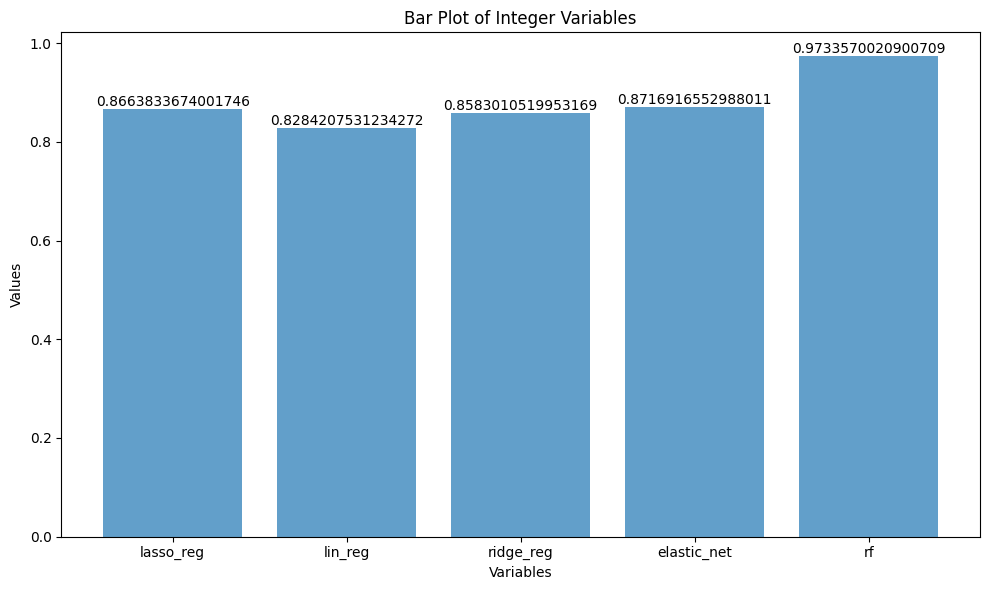

In [53]:
# Sample data (replace with your own integer variables and descriptions)
variables = [lasso_reg_score, lin_reg_score, ridge_reg_score, elastic_net_score, rf_score]
descriptions = ['lasso_reg', 'lin_reg', 'ridge_reg', 'elastic_net', 'rf']

# Create a bar plot
plt.figure(figsize=(10, 6))

# Plot the bars
plt.bar(range(len(variables)), variables, align='center', alpha=0.7)

# Add descriptions as labels to the bars
for i, var in enumerate(variables):
    plt.text(i, var, str(var), ha='center', va='bottom')

# Add x-axis labels (variable descriptions)
plt.xticks(range(len(variables)), descriptions)

# Add a title and labels
plt.title('Bar Plot of Integer Variables')
plt.xlabel('Variables')
plt.ylabel('Values')

# Display the plot
plt.tight_layout()
plt.show()


The Random Forest performs the best over all models.

# Feature importance
We want to look into the importance of our Features of the chosen Random Forest model

access_to_electricity : 0.5795910491959403
armed_forces : 0.016550477401616453
child_immunization : 0.017287849136188003
foreign_investm : 0.020464641331076377
gdp_per_cap : 0.12875445150568468
measels_immunitization : 0.03169218922008974
net_primary_income : 0.012793033503828793
perc_overweigth : 0.04669716042892922
primary_school_completion : 0.10456912583058212
rural_population : 0.027451289956970472
trade_in_services : 0.014148732489093955


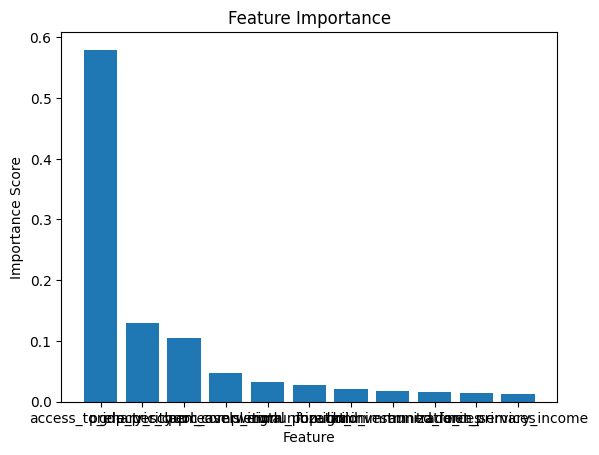

In [52]:
# Get the feature importances
feature_importances = rf.feature_importances_

# Get the names of the features
feature_names = x_train.columns 

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]


# Print the names and importances of the features
for name, importance in zip(feature_names, feature_importances):
    print(name, ":", importance)


# Create a bar plot
plt.figure()
plt.title("Feature Importance")
plt.bar(range(x_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(x_train.shape[1]), feature_names[indices])
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()